# Reconocimiento de Imágenes en CIFAR10

El conjunto de imágenes está compuesto por 60000 fotos RGB, de 32x32 pixeles. De ese conjunto, 50000 están dedicados a entrenamiento y el resto a testing.

In [1]:
def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

In [8]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### a.  Carga de los datos. Generación de los sets de entrenamiento, validación y pruebas.

In [1]:
from scipy.misc import imread
import cPickle as pickle
import numpy as np
import os
from sklearn.model_selection import train_test_split

def load_CIFAR_one(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f)
        X = datadict['data']
        Y = datadict['labels']
        return X, np.array(Y)
    
def load_CIFAR10(PATH):
    xs = []
    ys = []    
    for b in range(1,6):
        f = os.path.join(PATH, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_one(f)
        xs.append(X)
        ys.append(Y)
        
    # training set
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    
    # validation set 
    valset_size = 8000
    Xtr, Xval, Ytr, Yval = train_test_split(Xtr, Ytr, test_size=valset_size, random_state=42)    
    
    # Testing set 
    Xte, Yte = load_CIFAR_one(os.path.join(PATH, 'test_batch'))
    
    return Xtr, Ytr, Xval, Yval, Xte, Yte

In [2]:
Xtr, Ytr, Xval, Yval, Xte, Yte = load_CIFAR10('data')

#### Frecuencia de cada clase en el conjunto de entrenamiento

Como se puede observar abajo, las clases están bastante balanceadas.

In [17]:
counts = np.bincount(Ytr)
for label, count in zip(label_names, counts):
    print "{:<14}{:<11}".format(label, count)

airplane      4225       
automobile    4210       
bird          4179       
cat           4189       
deer          4259       
dog           4182       
frog          4198       
horse         4200       
ship          4181       
truck         4177       


### b. Escalamiento y centrado de los datos

In [3]:
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler

def scaler_function(X, scale=True):
    scaler = StandardScaler(with_std=scale).fit(X)
    return scaler.transform(X)


Using TensorFlow backend.


### c.  Clasificación con Redes neuronales

Se utiliza early stopping para encontrar el número óptimo de epochs.

In [4]:
Xtr_std = scaler_function(Xtr)
Xte_std = scaler_function(Xte)
Xval_std = scaler_function(Xval)

Ytr_cat = to_categorical(Ytr)
Yte_cat = to_categorical(Yte)
Yval_cat = to_categorical(Yval)

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [5]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

#### 0. Modelo original

In [29]:
model0 = Sequential()
model0.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model0.add(Dropout(0.1))
model0.add(Dense(10, init='uniform', activation='softmax'))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model0.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
es0 = EarlyStopping(monitor='val_acc', patience=5, verbose=0, mode='auto', min_delta=0.001)
model0.fit(Xtr_std, Ytr_cat, nb_epoch=50, batch_size=128, verbose=1, callbacks=[es0], validation_data=(Xval_std, Yval_cat))
model0.save('ann_models/model0.h5')

Train on 42000 samples, validate on 8000 samples
Epoch 1/50
42000/42000 [==============================] - 5s - loss: 0.2866 - acc: 0.9015 - val_loss: 0.2662 - val_acc: 0.9036
Epoch 2/50
42000/42000 [==============================] - 5s - loss: 0.2609 - acc: 0.9043 - val_loss: 0.2531 - val_acc: 0.9058
Epoch 3/50
42000/42000 [==============================] - 5s - loss: 0.2509 - acc: 0.9066 - val_loss: 0.2458 - val_acc: 0.9081
Epoch 4/50
42000/42000 [==============================] - 5s - loss: 0.2441 - acc: 0.9086 - val_loss: 0.2403 - val_acc: 0.9094
Epoch 5/50
42000/42000 [==============================] - 5s - loss: 0.2388 - acc: 0.9104 - val_loss: 0.2367 - val_acc: 0.9109
Epoch 6/50
42000/42000 [==============================] - 5s - loss: 0.2343 - acc: 0.9118 - val_loss: 0.2335 - val_acc: 0.9114
Epoch 7/50
42000/42000 [==============================] - 5s - loss: 0.2307 - acc: 0.9128 - val_loss: 0.2309 - val_acc: 0.9127
Epoch 8/50
42000/42000 [==============================] - 5s -

In [30]:
model0 = load_model('ann_models/model0.h5')
scores0 = model0.evaluate(Xval_std, Yval_cat)
print "\nAccuracy on validation set: {}".format(scores0[1])

8000/8000 [==============================] - 1s     

Accuracy on validation set: 0.916899999619


#### 1. Modelo original, con cambio en la función de pérdida, binary_crossentropy -> categorical_crossentropy (multiclass)

In [12]:
model1 = Sequential()
model1.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model1.add(Dropout(0.1))
model1.add(Dense(10, init='uniform', activation='softmax'))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
es1 = EarlyStopping(monitor='val_acc', patience=5, verbose=0, mode='auto', min_delta=0.001)
model1.fit(Xtr_std, Ytr_cat, nb_epoch=50, batch_size=128, verbose=1, callbacks=[es1], validation_data=(Xval_std, Yval_cat))
model1.save('ann_models/model1.h5')

Train on 42000 samples, validate on 8000 samples
Epoch 1/50
42000/42000 [==============================] - 5s - loss: 1.7367 - acc: 0.3829 - val_loss: 1.5974 - val_acc: 0.4296
Epoch 2/50
42000/42000 [==============================] - 5s - loss: 1.5552 - acc: 0.4520 - val_loss: 1.5327 - val_acc: 0.4646
Epoch 3/50
42000/42000 [==============================] - 5s - loss: 1.4823 - acc: 0.4799 - val_loss: 1.5276 - val_acc: 0.4600
Epoch 4/50
42000/42000 [==============================] - 5s - loss: 1.4295 - acc: 0.4964 - val_loss: 1.5073 - val_acc: 0.4763
Epoch 5/50
42000/42000 [==============================] - 5s - loss: 1.3920 - acc: 0.5127 - val_loss: 1.4626 - val_acc: 0.4855
Epoch 6/50
42000/42000 [==============================] - 5s - loss: 1.3489 - acc: 0.5272 - val_loss: 1.4721 - val_acc: 0.4851
Epoch 7/50
42000/42000 [==============================] - 5s - loss: 1.3246 - acc: 0.5361 - val_loss: 1.4604 - val_acc: 0.4879
Epoch 8/50
42000/42000 [==============================] - 5s -

In [14]:
model1 = load_model('ann_models/model1.h5')
scores1 = model1.evaluate(Xval_std, Yval_cat)
print "\nAccuracy on validation set: {}".format(scores1[1])

7936/8000 [============================>.] - ETA: 0s
Accuracy on validation set: 0.505375


Si se compara el modelo 0 con el 1, el primero tiende a sobreestimar el accuracy de clasificación de las imágenes. Esto se debe a la función de pérdida a minimizar por el modelo, **binary_crossentropy**, se utiliza para clasificación binaria. Pero el problema actual es *multiclass* (mayor a 2 clases), por lo que lo correcto es utilizar **categorical_crossentropy**.

#### 2.  Modelo 1 con aumento en el número de epochs (50 -> 100)

In [10]:
model2 = Sequential()
model2.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model2.add(Dropout(0.1))
model2.add(Dense(10, init='uniform', activation='softmax'))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model2.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
es2 = EarlyStopping(monitor='val_acc', patience=10, verbose=0, mode='auto', min_delta=0.001)
model2.fit(Xtr_std, Ytr_cat, nb_epoch=100, batch_size=128, verbose=1, callbacks=[es2], validation_data=(Xval_std, Yval_cat))
model2.save('ann_models/model2.h5')

Train on 42000 samples, validate on 8000 samples
Epoch 1/100
42000/42000 [==============================] - 5s - loss: 1.7348 - acc: 0.3861 - val_loss: 1.5972 - val_acc: 0.4315
Epoch 2/100
42000/42000 [==============================] - 5s - loss: 1.5549 - acc: 0.4544 - val_loss: 1.5223 - val_acc: 0.4607
Epoch 3/100
42000/42000 [==============================] - 5s - loss: 1.4829 - acc: 0.4790 - val_loss: 1.5007 - val_acc: 0.4740
Epoch 4/100
42000/42000 [==============================] - 5s - loss: 1.4365 - acc: 0.4962 - val_loss: 1.4720 - val_acc: 0.4810
Epoch 5/100
42000/42000 [==============================] - 5s - loss: 1.3961 - acc: 0.5109 - val_loss: 1.4453 - val_acc: 0.4931
Epoch 6/100
42000/42000 [==============================] - 5s - loss: 1.3567 - acc: 0.5238 - val_loss: 1.4327 - val_acc: 0.5008
Epoch 7/100
42000/42000 [==============================] - 5s - loss: 1.3291 - acc: 0.5352 - val_loss: 1.4656 - val_acc: 0.4873
Epoch 8/100
42000/42000 [==============================

In [11]:
model2 = load_model('ann_models/model2.h5')
scores2 = model2.evaluate(Xval_std, Yval_cat)
print "\nAccuracy on validation set: {}".format(scores2[1])

7936/8000 [============================>.] - ETA: 0s
Accuracy on validation set: 0.509375


#### 3. Modelo con 2 capas ocultas

In [6]:
model3 = Sequential()
model3.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model3.add(Dropout(0.1))
model3.add(Dense(100, init='uniform', activation='relu'))
model3.add(Dropout(0.1))
model3.add(Dense(10, init='uniform', activation='softmax'))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model3.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
es3 = EarlyStopping(monitor='val_acc', patience=5, verbose=0, mode='auto', min_delta=0.001)
model3.fit(Xtr_std, Ytr_cat, nb_epoch=50, batch_size=128, verbose=1, callbacks=[es3], validation_data=(Xval_std, Yval_cat))
model3.save('ann_models/model3.h5')

Train on 42000 samples, validate on 8000 samples
Epoch 1/50
42000/42000 [==============================] - 6s - loss: 1.8502 - acc: 0.3362 - val_loss: 1.6216 - val_acc: 0.4220
Epoch 2/50
42000/42000 [==============================] - 5s - loss: 1.5910 - acc: 0.4351 - val_loss: 1.5411 - val_acc: 0.4474
Epoch 3/50
42000/42000 [==============================] - 5s - loss: 1.4956 - acc: 0.4691 - val_loss: 1.4678 - val_acc: 0.4789
Epoch 4/50
42000/42000 [==============================] - 6s - loss: 1.4413 - acc: 0.4899 - val_loss: 1.4327 - val_acc: 0.4949
Epoch 5/50
42000/42000 [==============================] - 6s - loss: 1.3892 - acc: 0.5073 - val_loss: 1.3986 - val_acc: 0.5072
Epoch 6/50
42000/42000 [==============================] - 5s - loss: 1.3482 - acc: 0.5216 - val_loss: 1.3980 - val_acc: 0.5069
Epoch 7/50
42000/42000 [==============================] - 6s - loss: 1.3229 - acc: 0.5331 - val_loss: 1.3878 - val_acc: 0.5101
Epoch 8/50
42000/42000 [==============================] - 5s -

In [7]:
model3 = load_model('ann_models/model3.h5')
scores3 = model3.evaluate(Xval_std, Yval_cat)
print "\nAccuracy on validation set: {}".format(scores3[1])

7936/8000 [============================>.] - ETA: 0s
Accuracy on validation set: 0.533125


#### 4. Modelo con 3 capas ocultas

In [8]:
model4 = Sequential()
model4.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model4.add(Dropout(0.1))
model4.add(Dense(100, init='uniform', activation='relu'))
model4.add(Dropout(0.1))
model4.add(Dense(100, init='uniform', activation='relu'))
model4.add(Dropout(0.1))
model4.add(Dense(10, init='uniform', activation='softmax'))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model4.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
es4 = EarlyStopping(monitor='val_acc', patience=5, verbose=0, mode='auto', min_delta=0.001)
model4.fit(Xtr_std, Ytr_cat, nb_epoch=50, batch_size=128, verbose=1, callbacks=[es4], validation_data=(Xval_std, Yval_cat))
model4.save('ann_models/model4.h5')

Train on 42000 samples, validate on 8000 samples
Epoch 1/50
42000/42000 [==============================] - 6s - loss: 2.0740 - acc: 0.2306 - val_loss: 1.8019 - val_acc: 0.3463
Epoch 2/50
42000/42000 [==============================] - 6s - loss: 1.7207 - acc: 0.3810 - val_loss: 1.6231 - val_acc: 0.4099
Epoch 3/50
42000/42000 [==============================] - 6s - loss: 1.5904 - acc: 0.4321 - val_loss: 1.5491 - val_acc: 0.4481
Epoch 4/50
42000/42000 [==============================] - 6s - loss: 1.5104 - acc: 0.4615 - val_loss: 1.5019 - val_acc: 0.4611
Epoch 5/50
42000/42000 [==============================] - 6s - loss: 1.4547 - acc: 0.4797 - val_loss: 1.4529 - val_acc: 0.4918
Epoch 6/50
42000/42000 [==============================] - 6s - loss: 1.4029 - acc: 0.5019 - val_loss: 1.4203 - val_acc: 0.4916
Epoch 7/50
42000/42000 [==============================] - 6s - loss: 1.3652 - acc: 0.5132 - val_loss: 1.4161 - val_acc: 0.4934
Epoch 8/50
42000/42000 [==============================] - 6s -

In [9]:
model4 = load_model('ann_models/model4.h5')
scores4 = model4.evaluate(Xval_std, Yval_cat)
print "\nAccuracy on validation set: {}".format(scores4[1])

7936/8000 [============================>.] - ETA: 0s
Accuracy on validation set: 0.53925


#### 5. Modelo 3 con capas ocultas mas anchas

In [19]:
model5 = Sequential()
model5.add(Dense(256, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model5.add(Dropout(0.1))
model5.add(Dense(256, init='uniform', activation='relu'))
model5.add(Dropout(0.1))
model5.add(Dense(10, init='uniform', activation='softmax'))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model5.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
es5 = EarlyStopping(monitor='val_acc', patience=5, verbose=0, mode='auto', min_delta=0.001)
model5.fit(Xtr_std, Ytr_cat, nb_epoch=50, batch_size=128, callbacks=[es5], validation_data=(Xval_std, Yval_cat))
model5.save('ann_models/model5.h5')

Train on 42000 samples, validate on 8000 samples
Epoch 1/50
42000/42000 [==============================] - 11s - loss: 1.7589 - acc: 0.3750 - val_loss: 1.5857 - val_acc: 0.4360
Epoch 2/50
42000/42000 [==============================] - 11s - loss: 1.5172 - acc: 0.4616 - val_loss: 1.4837 - val_acc: 0.4716
Epoch 3/50
42000/42000 [==============================] - 11s - loss: 1.4174 - acc: 0.4989 - val_loss: 1.4267 - val_acc: 0.4968
Epoch 4/50
42000/42000 [==============================] - 10s - loss: 1.3423 - acc: 0.5240 - val_loss: 1.4002 - val_acc: 0.5079
Epoch 5/50
42000/42000 [==============================] - 10s - loss: 1.2798 - acc: 0.5478 - val_loss: 1.3875 - val_acc: 0.5168
Epoch 6/50
42000/42000 [==============================] - 10s - loss: 1.2316 - acc: 0.5664 - val_loss: 1.3642 - val_acc: 0.5180
Epoch 7/50
42000/42000 [==============================] - 10s - loss: 1.1852 - acc: 0.5797 - val_loss: 1.3524 - val_acc: 0.5305
Epoch 8/50
42000/42000 [==============================]

In [26]:
model5 = load_model('ann_models/model5.h5')
scores5 = model5.evaluate(Xval_std, Yval_cat)
print "\nAccuracy on validation set: {}".format(scores5[1])

8000/8000 [==============================] - 1s     

Accuracy on validation set: 0.540375


#### 6. Modelo 5 con aumento en el Dropout

In [24]:
model6 = Sequential()
model6.add(Dense(256, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model6.add(Dropout(0.3))
model6.add(Dense(256, init='uniform', activation='relu'))
model6.add(Dropout(0.3))
model6.add(Dense(10, init='uniform', activation='softmax'))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model6.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
es6 = EarlyStopping(monitor='val_acc', patience=5, verbose=0, mode='auto', min_delta=0.001)
model6.fit(Xtr_std, Ytr_cat, nb_epoch=50, batch_size=128, verbose=1, callbacks=[es6], validation_data=(Xval_std, Yval_cat))
model6.save('ann_models/model6.h5')

Train on 42000 samples, validate on 8000 samples
Epoch 1/50
42000/42000 [==============================] - 11s - loss: 1.8152 - acc: 0.3514 - val_loss: 1.6078 - val_acc: 0.4224
Epoch 2/50
42000/42000 [==============================] - 10s - loss: 1.6141 - acc: 0.4255 - val_loss: 1.5189 - val_acc: 0.4634
Epoch 3/50
42000/42000 [==============================] - 10s - loss: 1.5381 - acc: 0.4573 - val_loss: 1.4823 - val_acc: 0.4784
Epoch 4/50
42000/42000 [==============================] - 10s - loss: 1.4854 - acc: 0.4735 - val_loss: 1.4371 - val_acc: 0.4921
Epoch 5/50
42000/42000 [==============================] - 10s - loss: 1.4455 - acc: 0.4875 - val_loss: 1.4084 - val_acc: 0.5024
Epoch 6/50
42000/42000 [==============================] - 10s - loss: 1.4095 - acc: 0.5030 - val_loss: 1.3870 - val_acc: 0.5111
Epoch 7/50
42000/42000 [==============================] - 10s - loss: 1.3853 - acc: 0.5087 - val_loss: 1.3761 - val_acc: 0.5100
Epoch 8/50
42000/42000 [==============================]

In [25]:
model6 = load_model('ann_models/model6.h5')
scores6 = model6.evaluate(Xval_std, Yval_cat)
print "\nAccuracy on validation set: {}".format(scores6[1])

7936/8000 [============================>.] - ETA: 0s
Accuracy on validation set: 0.538125


#### Mejor modelo: 5

In [27]:
model5 = load_model('ann_models/model5.h5')
scores5 = model5.evaluate(Xte_std, Yte_cat)
print "\nAccuracy on testing set: {}".format(scores5[1])

10000/10000 [==============================] - 1s     

Accuracy on testing set: 0.5358


### d.  Clasificación con redes neuronales usando características de alto nivel

Se utilizó el mejor modelo obtenido en el ítem anterior, el modelo 5.

In [2]:
from top_level_features import hog_features
from top_level_features import color_histogram_hsv
from top_level_features import extract_features

#### Modelo 5 con Histograma de color

In [39]:
features_tr = extract_features(Xtr, [color_histogram_hsv]) 
features_te = extract_features(Xte, [color_histogram_hsv])
features_val = extract_features(Xval, [color_histogram_hsv])

print features_tr.shape

(42000, 32, 32, 3)
(10000, 32, 32, 3)
(8000, 32, 32, 3)
(42000, 10)


In [31]:
model5_hc = Sequential()
model5_hc.add(Dense(256, input_dim=features_tr.shape[1], init='uniform', activation='relu'))
model5_hc.add(Dropout(0.1))
model5_hc.add(Dense(256, init='uniform', activation='relu'))
model5_hc.add(Dropout(0.1))
model5_hc.add(Dense(10, init='uniform', activation='softmax'))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model5_hc.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
es5 = EarlyStopping(monitor='val_acc', patience=5, verbose=0, mode='auto', min_delta=0.001)
model5_hc.fit(features_tr, Ytr_cat, nb_epoch=50, batch_size=128, callbacks=[es5], validation_data=(features_val, Yval_cat))
model5_hc.save('ann_models/model5_hc.h5')

Train on 42000 samples, validate on 8000 samples
Epoch 1/50
42000/42000 [==============================] - 3s - loss: 2.2990 - acc: 0.1335 - val_loss: 2.2922 - val_acc: 0.1774
Epoch 2/50
42000/42000 [==============================] - 2s - loss: 2.2479 - acc: 0.1805 - val_loss: 2.1590 - val_acc: 0.1817
Epoch 3/50
42000/42000 [==============================] - 2s - loss: 2.1182 - acc: 0.1959 - val_loss: 2.1031 - val_acc: 0.2035
Epoch 4/50
42000/42000 [==============================] - 2s - loss: 2.0950 - acc: 0.2068 - val_loss: 2.0839 - val_acc: 0.2114
Epoch 5/50
42000/42000 [==============================] - 2s - loss: 2.0752 - acc: 0.2141 - val_loss: 2.0693 - val_acc: 0.2115
Epoch 6/50
42000/42000 [==============================] - 2s - loss: 2.0638 - acc: 0.2195 - val_loss: 2.0608 - val_acc: 0.2149
Epoch 7/50
42000/42000 [==============================] - 2s - loss: 2.0570 - acc: 0.2225 - val_loss: 2.0548 - val_acc: 0.2283
Epoch 8/50
42000/42000 [==============================] - 2s -

In [40]:
model5_hc = load_model('ann_models/model5_hc.h5')
scores5_hc = model5_hc.evaluate(features_val, Yval_cat)
print "\nAccuracy on validation set: {}".format(scores5_hc[1])

7808/8000 [============================>.] - ETA: 0s
Accuracy on validation set: 0.265875


#### Modelo 5 con Hog features

In [37]:
features_tr = extract_features(Xtr, [hog_features])
features_te = extract_features(Xte, [hog_features])
features_val = extract_features(Xval, [hog_features])

print features_tr.shape

(42000, 32, 32, 3)
(10000, 32, 32, 3)
(8000, 32, 32, 3)
(42000, 144)


In [34]:
model5_hog = Sequential()
model5_hog.add(Dense(256, input_dim=features_tr.shape[1], init='uniform', activation='relu'))
model5_hog.add(Dropout(0.1))
model5_hog.add(Dense(256, init='uniform', activation='relu'))
model5_hog.add(Dropout(0.1))
model5_hog.add(Dense(10, init='uniform', activation='softmax'))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model5_hog.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
es5 = EarlyStopping(monitor='val_acc', patience=5, verbose=0, mode='auto', min_delta=0.001)
model5_hog.fit(features_tr, Ytr_cat, nb_epoch=50, batch_size=128, callbacks=[es5], validation_data=(features_val, Yval_cat))
model5_hog.save('ann_models/model5_hog.h5')

Train on 42000 samples, validate on 8000 samples
Epoch 1/50
42000/42000 [==============================] - 3s - loss: 1.7362 - acc: 0.3829 - val_loss: 1.5465 - val_acc: 0.4589
Epoch 2/50
42000/42000 [==============================] - 3s - loss: 1.4736 - acc: 0.4882 - val_loss: 1.4236 - val_acc: 0.5088
Epoch 3/50
42000/42000 [==============================] - 3s - loss: 1.3816 - acc: 0.5185 - val_loss: 1.3658 - val_acc: 0.5281
Epoch 4/50
42000/42000 [==============================] - 3s - loss: 1.3109 - acc: 0.5462 - val_loss: 1.3360 - val_acc: 0.5324
Epoch 5/50
42000/42000 [==============================] - 3s - loss: 1.2588 - acc: 0.5625 - val_loss: 1.3417 - val_acc: 0.5333
Epoch 6/50
42000/42000 [==============================] - 3s - loss: 1.2134 - acc: 0.5785 - val_loss: 1.2952 - val_acc: 0.5461
Epoch 7/50
42000/42000 [==============================] - 3s - loss: 1.1810 - acc: 0.5876 - val_loss: 1.2623 - val_acc: 0.5610
Epoch 8/50
42000/42000 [==============================] - 3s -

In [38]:
model5_hog = load_model('ann_models/model5_hog.h5')
scores5_hog = model5_hog.evaluate(features_val, Yval_cat)
print "\nAccuracy on validation set: {}".format(scores5_hog[1])

7840/8000 [============================>.] - ETA: 0s
Accuracy on validation set: 0.564


#### Modelo 5 con Histogramas de color y hog features

In [41]:
features_tr = extract_features(Xtr, [hog_features, color_histogram_hsv])
features_te = extract_features(Xte, [hog_features, color_histogram_hsv])
features_val = extract_features(Xval, [hog_features, color_histogram_hsv])

print features_tr.shape

(42000, 32, 32, 3)
(10000, 32, 32, 3)
(8000, 32, 32, 3)
(42000, 154)


In [42]:
model5_all = Sequential()
model5_all.add(Dense(256, input_dim=features_tr.shape[1], init='uniform', activation='relu'))
model5_all.add(Dropout(0.1))
model5_all.add(Dense(256, init='uniform', activation='relu'))
model5_all.add(Dropout(0.1))
model5_all.add(Dense(10, init='uniform', activation='softmax'))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model5_all.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
es5 = EarlyStopping(monitor='val_acc', patience=5, verbose=0, mode='auto', min_delta=0.001)
model5_all.fit(features_tr, Ytr_cat, nb_epoch=50, batch_size=128, callbacks=[es5], validation_data=(features_val, Yval_cat))
model5_all.save('ann_models/model5_all.h5')

Train on 42000 samples, validate on 8000 samples
Epoch 1/50
42000/42000 [==============================] - 3s - loss: 1.7259 - acc: 0.3914 - val_loss: 1.5009 - val_acc: 0.4804
Epoch 2/50
42000/42000 [==============================] - 3s - loss: 1.4514 - acc: 0.4934 - val_loss: 1.3852 - val_acc: 0.5212
Epoch 3/50
42000/42000 [==============================] - 3s - loss: 1.3479 - acc: 0.5310 - val_loss: 1.3305 - val_acc: 0.5354
Epoch 4/50
42000/42000 [==============================] - 3s - loss: 1.2761 - acc: 0.5575 - val_loss: 1.2900 - val_acc: 0.5454
Epoch 5/50
42000/42000 [==============================] - 3s - loss: 1.2172 - acc: 0.5747 - val_loss: 1.2572 - val_acc: 0.5660
Epoch 6/50
42000/42000 [==============================] - 3s - loss: 1.1729 - acc: 0.5904 - val_loss: 1.2971 - val_acc: 0.5535
Epoch 7/50
42000/42000 [==============================] - 3s - loss: 1.1314 - acc: 0.6028 - val_loss: 1.2677 - val_acc: 0.5596
Epoch 8/50
42000/42000 [==============================] - 3s -

In [43]:
model5_all = load_model('ann_models/model5_all.h5')
scores5_all = model5_all.evaluate(features_val, Yval_cat)
print "\nAccuracy on validation set: {}".format(scores5_all[1])

7872/8000 [============================>.] - ETA: 0s
Accuracy on validation set: 0.58025


#### Modelo 5 con Histogramas de color y hog features en testing set

In [45]:
scores5_all = model5_all.evaluate(features_te, Yte_cat)
print "\nAccuracy on testing set: {}".format(scores5_all[1])

 9920/10000 [============================>.] - ETA: 0s
Accuracy on testing set: 0.5853


Los resultados muestran que el mejor rendimiento se obtiene cuando se utilizan los hog features (sólos o en conjunto con histrogramas de color), alcanzado un accuracy sobre el 58%, superior al obtenido con la data original y escalada.

### e. Clasificación con SVM no lineal

De http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html:

> *The implementation is based on libsvm. The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to dataset with more than a couple of 10000 samples.*

Por esta razón, se reducirá el training set a un máximo de 10000 elementos, elegidos de forma aleatoria.


In [2]:
Xtr, Ytr, Xval, Yval, Xte, Yte = load_CIFAR10('data')
print Xtr.shape

(42000, 3072)


In [3]:
import random
training_data = random.sample(zip(Xtr, Ytr), 10000)
Xtr, Ytr = zip(*training_data)
Xtr = np.array(Xtr)
Ytr = np.array(Ytr)
print Xtr.shape

(10000, 3072)


In [9]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

In [8]:
from sklearn.svm import SVC

def svm_test(Xtr, Ytr, Xval, Yval):
    non_linear_svc = {'rbf': SVC(kernel='rbf', cache_size=1000), 'poly': SVC(kernel='poly', degree=2, coef0=1, cache_size=1000)}
    C = np.logspace(-2, 1, 6)
    fig, axs = plt.subplots(ncols=2, figsize=(18, 6), sharey=True)
    fig.tight_layout()
    for i, kernel in enumerate(non_linear_svc.keys()):
        datapoints = {'training':[], 'validation':[]}
        model = non_linear_svc[kernel]
        for c in C:
            model.set_params(C=c)
            model.fit(Xtr, Ytr)
            tr_error = 1 - model.score(Xtr, Ytr)
            val_error = 1 - model.score(Xval, Yval)
            datapoints['training'].append((c, tr_error))
            datapoints['validation'].append((c, val_error))
            print "Model: {} - C: {} - train error: {} - val error: {}".format(kernel, c, tr_error, val_error)
        axs[i].plot(*zip(*datapoints['training']), label='training set')
        axs[i].plot(*zip(*datapoints['validation']), label='validation set')
        axs[i].set_xlabel('C parameter', size=18)
        axs[i].set_ylabel('Error', size=18)
        axs[i].legend(loc="center right", prop={'size':16})  
        axs[i].set_title(kernel + ' kernel', size=24)
        axs[i].yaxis.set_tick_params(labelsize=16)
        axs[i].xaxis.set_tick_params(labelsize=14)

#### Píxeles originales

Model: rbf - C: 0.01 - train error: 0.8974 - val error: 0.89975
Model: rbf - C: 0.0398107170553 - train error: 0.8974 - val error: 0.89975
Model: rbf - C: 0.158489319246 - train error: 0.8974 - val error: 0.89975
Model: rbf - C: 0.63095734448 - train error: 0.0 - val error: 0.89975
Model: rbf - C: 2.51188643151 - train error: 0.0 - val error: 0.89975
Model: rbf - C: 10.0 - train error: 0.0 - val error: 0.89975
Model: poly - C: 0.01 - train error: 0.0 - val error: 0.5915
Model: poly - C: 0.0398107170553 - train error: 0.0 - val error: 0.5915
Model: poly - C: 0.158489319246 - train error: 0.0 - val error: 0.5915
Model: poly - C: 0.63095734448 - train error: 0.0 - val error: 0.5915
Model: poly - C: 2.51188643151 - train error: 0.0 - val error: 0.5915
Model: poly - C: 10.0 - train error: 0.0 - val error: 0.5915


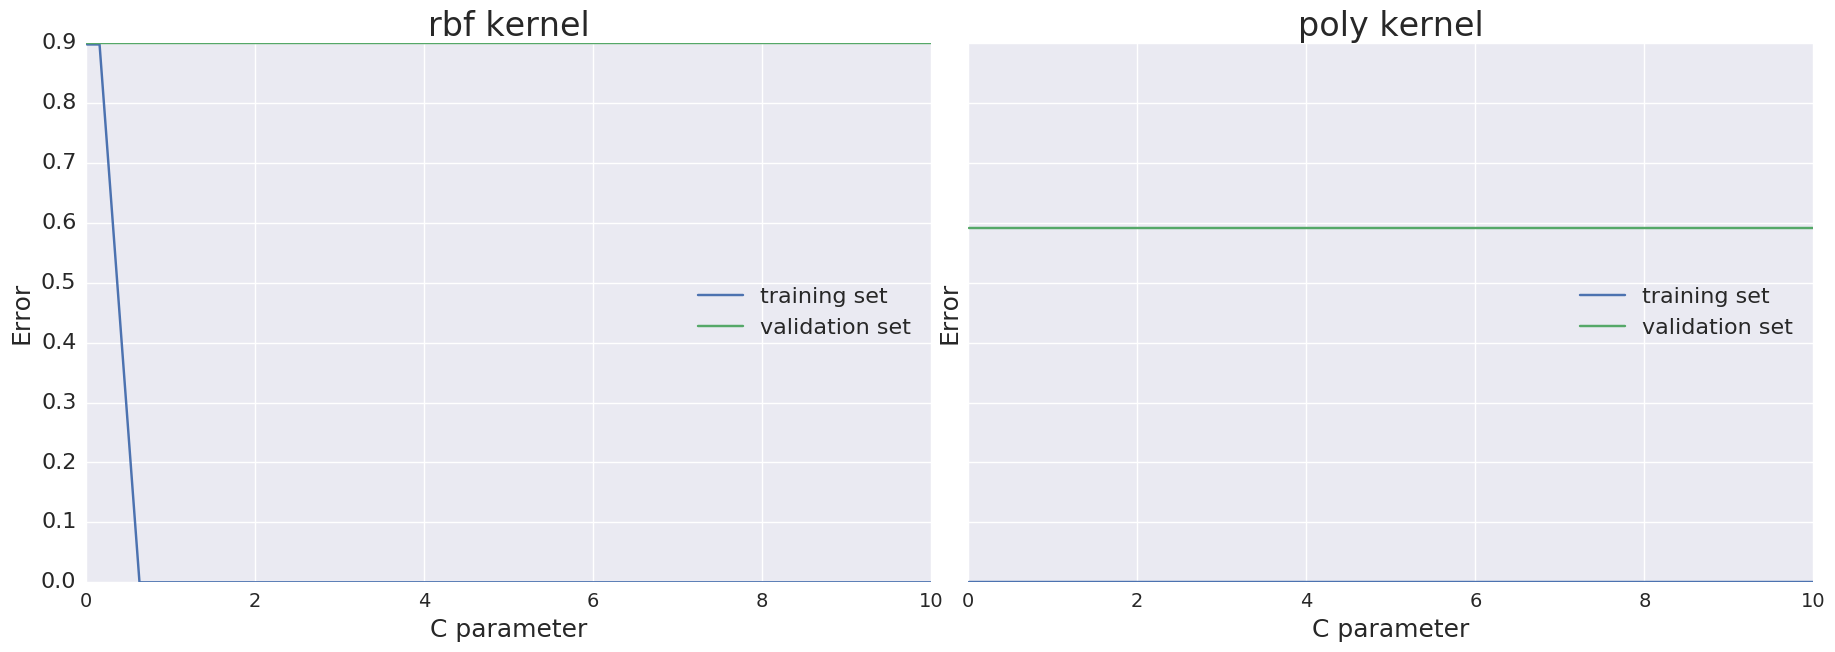

In [15]:
svm_test(Xtr, Ytr, Xval, Yval)

#### Histogramas de color

In [9]:
features_tr = extract_features(Xtr, [color_histogram_hsv]) 
features_te = extract_features(Xte, [color_histogram_hsv])
features_val = extract_features(Xval, [color_histogram_hsv])

print features_tr.shape

(10000, 32, 32, 3)
(10000, 32, 32, 3)
(8000, 32, 32, 3)
(10000, 10)


Model: rbf - C: 0.01 - train error: 0.8974 - val error: 0.89975
Model: rbf - C: 0.0398107170553 - train error: 0.8253 - val error: 0.82575
Model: rbf - C: 0.158489319246 - train error: 0.7806 - val error: 0.7775
Model: rbf - C: 0.63095734448 - train error: 0.7687 - val error: 0.763625
Model: rbf - C: 2.51188643151 - train error: 0.7621 - val error: 0.757875
Model: rbf - C: 10.0 - train error: 0.7527 - val error: 0.757375
Model: poly - C: 0.01 - train error: 0.8972 - val error: 0.899625
Model: poly - C: 0.0398107170553 - train error: 0.8173 - val error: 0.8185
Model: poly - C: 0.158489319246 - train error: 0.7805 - val error: 0.779875
Model: poly - C: 0.63095734448 - train error: 0.7713 - val error: 0.76675
Model: poly - C: 2.51188643151 - train error: 0.7676 - val error: 0.765125
Model: poly - C: 10.0 - train error: 0.7626 - val error: 0.76175


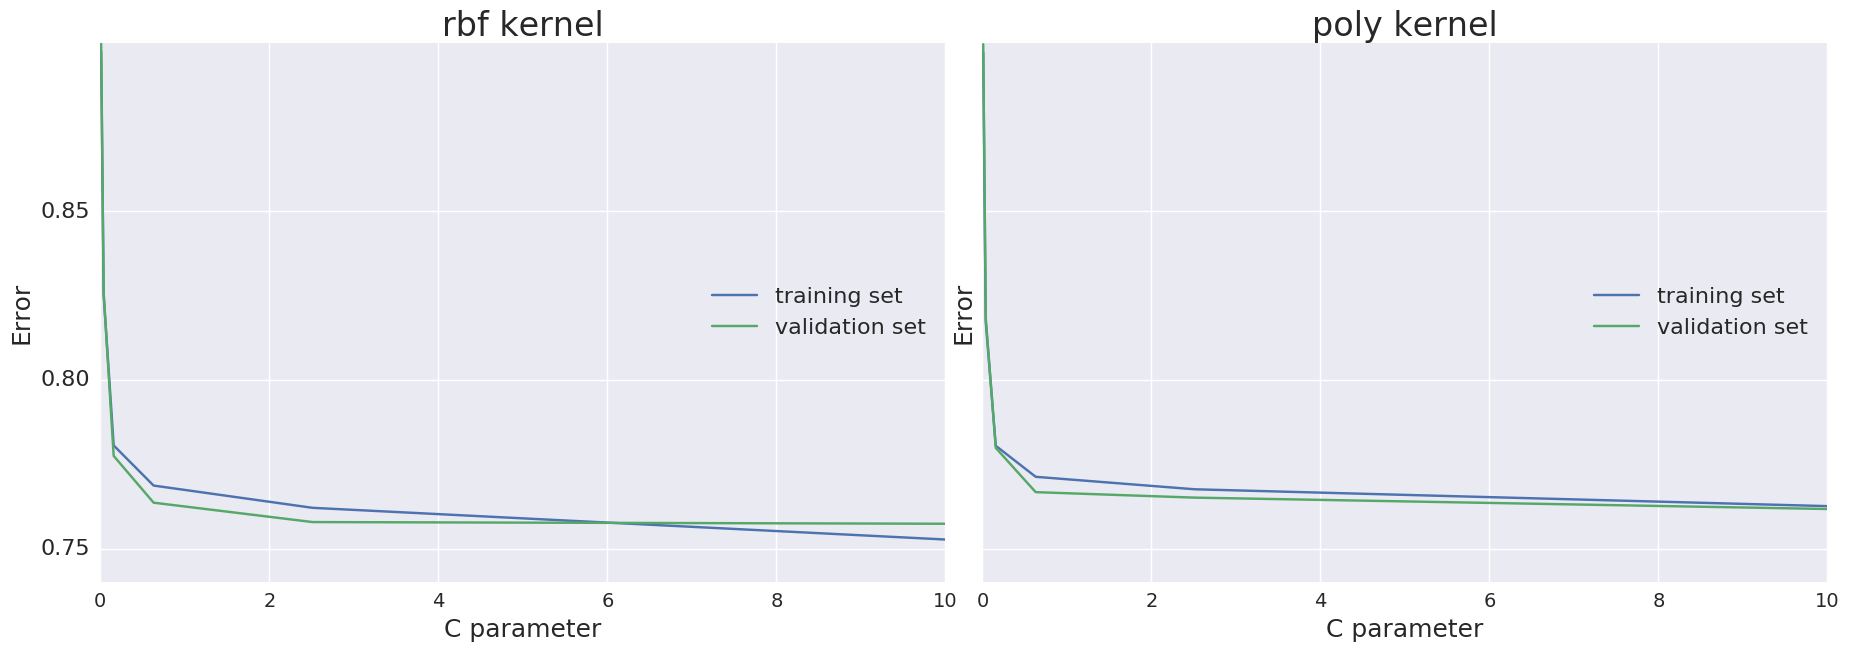

In [10]:
svm_test(features_tr, Ytr, features_val, Yval)

#### Hog features

In [11]:
features_tr = extract_features(Xtr, [hog_features])
features_te = extract_features(Xte, [hog_features])
features_val = extract_features(Xval, [hog_features])

print features_tr.shape

(10000, 32, 32, 3)
(10000, 32, 32, 3)
(8000, 32, 32, 3)
(10000, 144)


Model: rbf - C: 0.01 - train error: 0.8974 - val error: 0.89975
Model: rbf - C: 0.0398107170553 - train error: 0.8086 - val error: 0.82575
Model: rbf - C: 0.158489319246 - train error: 0.6568 - val error: 0.72475
Model: rbf - C: 0.63095734448 - train error: 0.125 - val error: 0.604375
Model: rbf - C: 2.51188643151 - train error: 0.0053 - val error: 0.53
Model: rbf - C: 10.0 - train error: 0.0 - val error: 0.532
Model: poly - C: 0.01 - train error: 0.4567 - val error: 0.531375
Model: poly - C: 0.0398107170553 - train error: 0.3479 - val error: 0.496375
Model: poly - C: 0.158489319246 - train error: 0.1885 - val error: 0.482
Model: poly - C: 0.63095734448 - train error: 0.0575 - val error: 0.489375
Model: poly - C: 2.51188643151 - train error: 0.0072 - val error: 0.49875
Model: poly - C: 10.0 - train error: 0.0005 - val error: 0.5005


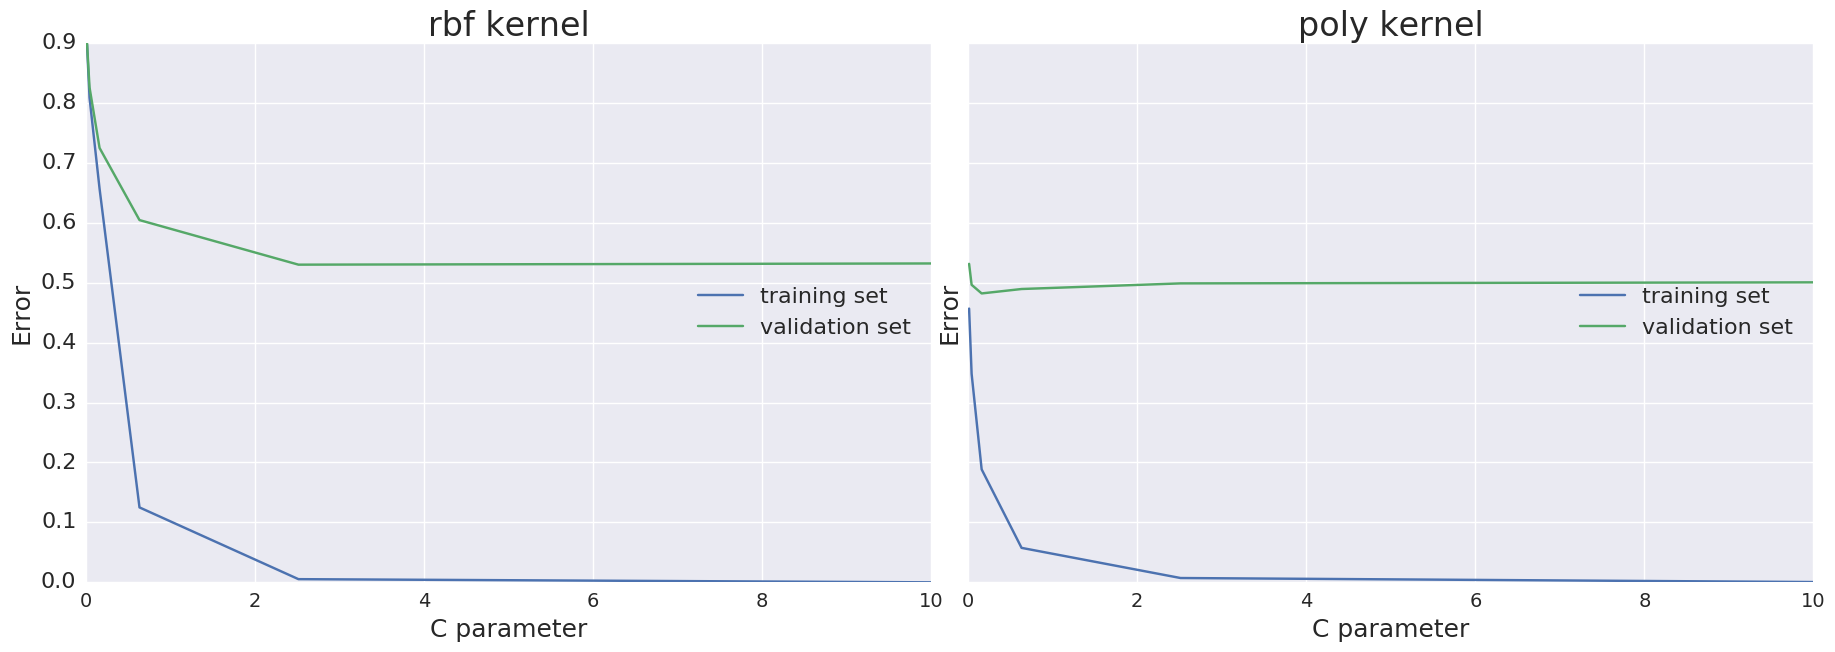

In [12]:
svm_test(features_tr, Ytr, features_val, Yval)

#### All features

In [13]:
features_tr = extract_features(Xtr, [hog_features, color_histogram_hsv])
features_te = extract_features(Xte, [hog_features, color_histogram_hsv])
features_val = extract_features(Xval, [hog_features, color_histogram_hsv])

print features_tr.shape

(10000, 32, 32, 3)
(10000, 32, 32, 3)
(8000, 32, 32, 3)
(10000, 154)


Model: rbf - C: 0.01 - train error: 0.8974 - val error: 0.89975
Model: rbf - C: 0.0398107170553 - train error: 0.73 - val error: 0.78675
Model: rbf - C: 0.158489319246 - train error: 0.6281 - val error: 0.705125
Model: rbf - C: 0.63095734448 - train error: 0.1321 - val error: 0.58875
Model: rbf - C: 2.51188643151 - train error: 0.0058 - val error: 0.518375
Model: rbf - C: 10.0 - train error: 0.0 - val error: 0.52075
Model: poly - C: 0.01 - train error: 0.4645 - val error: 0.531
Model: poly - C: 0.0398107170553 - train error: 0.3562 - val error: 0.495875
Model: poly - C: 0.158489319246 - train error: 0.1955 - val error: 0.474375
Model: poly - C: 0.63095734448 - train error: 0.0606 - val error: 0.476625
Model: poly - C: 2.51188643151 - train error: 0.0076 - val error: 0.484125
Model: poly - C: 10.0 - train error: 0.0006 - val error: 0.493625


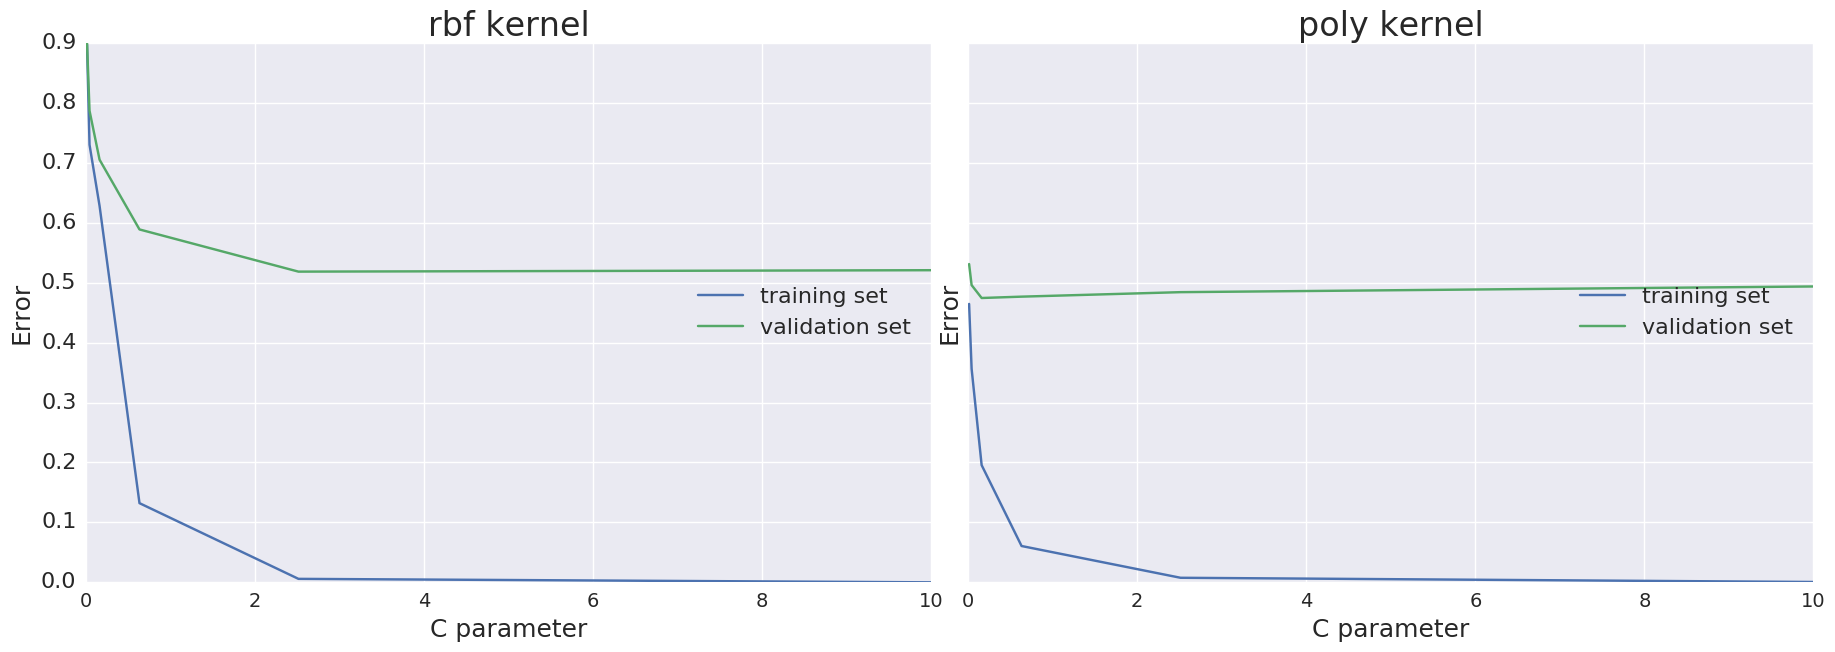

In [14]:
svm_test(features_tr, Ytr, features_val, Yval)

Con los píxeles originales se observa una especie de no convergencia, los errores no varían con el cambio en el parámetro de penalización C. Aunque los datos de entrenamiento se disminuyeron a 10000, de todas formas el fit de las SVM tomó bastante tiempo. Sin duda, el utilizar las características de alto nivel ayudó a diminuir la dimensionalidad de los datos, diminuyendo los tiempos de entrenamiento y obteniendo un menor error. 

Al utilizar los histogramas de color, el kernel rbf obtiene un ligero menor error. Con hog features, el kernel polinomial de grado 2, obtiene los mejores resultados. Finalmente, cuando se utilizan las dos características de alto nivel en conjunto, el kernel polinomial obtiene los mejores resultados. Probablemente el aumentar los grados del polinomio puede se aumente la potencia de predicción de la SVM polinomial.

#### Ensemble Classifier (Bagging SVC with poly kernel)

In [60]:
Xtr, Ytr, Xval, Yval, Xte, Yte = load_CIFAR10('data')

features_tr = extract_features(Xtr, [hog_features])
features_te = extract_features(Xte, [hog_features])
features_val = extract_features(Xval, [hog_features])

print features_tr.shape

(42000, 32, 32, 3)
(10000, 32, 32, 3)
(8000, 32, 32, 3)
(42000, 144)


In [64]:
from sklearn.ensemble import BaggingClassifier
n_estimators = 10
clf = BaggingClassifier(SVC(kernel='poly', degree=2, coef0=1, cache_size=500), max_samples=1.0/n_estimators, n_estimators=n_estimators, verbose=1, random_state=42)
clf.fit(features_tr, Ytr)
print "Bagging SVC score: {}".format(clf.score(features_val, Yval))

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.0s finished


Bagging SVC score: 0.523375


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.6s finished


### f. Clasificación con árboles de decisión

In [3]:
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.metrics import accuracy_score

def tree_test(Xtr, Ytr, Xval, Yval, title):
    K = np.arange(1, 7)
    errors = {'training':[], 'validation':[]}
    clf = Tree(criterion='gini', splitter='best', random_state=0)

    for k in K:    
        l = 2**k
        clf.set_params(max_depth=l)
        clf.fit(Xtr, Ytr)

        # Training set
        Y_pred = clf.predict(Xtr)
        errors['training'].append((l, 1 - accuracy_score(Ytr, Y_pred)))

        # Validation set
        Y_pred = clf.predict(Xval)
        errors['validation'].append((l, 1 - accuracy_score(Yval, Y_pred)))
        
    # Plotting   
    fig, ax = plt.subplots(ncols=1, figsize=(5, 4))
    fig.tight_layout()
    for dataset, error_points in errors.iteritems():
        ax.plot(*zip(*error_points), label=dataset + ' set')        
    ax.set_xlabel(u'Niveles del árbol')
    ax.set_ylabel('Error')
    ax.legend(loc="center right")  
    ax.set_title(title)

#### Cargando los datos

In [6]:
Xtr, Ytr, Xval, Yval, Xte, Yte = load_CIFAR10('data')

#### Píxeles originales

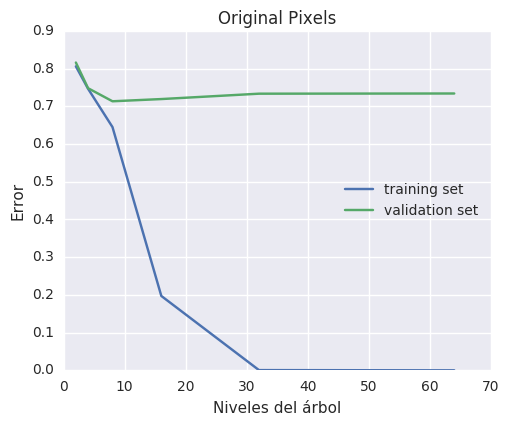

In [70]:
tree_test(Xtr, Ytr, Xval, Yval, 'Original Pixels')

#### Histogramas de color

In [71]:
features_tr = extract_features(Xtr, [color_histogram_hsv]) 
features_te = extract_features(Xte, [color_histogram_hsv])
features_val = extract_features(Xval, [color_histogram_hsv])

(42000, 32, 32, 3)
(10000, 32, 32, 3)
(8000, 32, 32, 3)


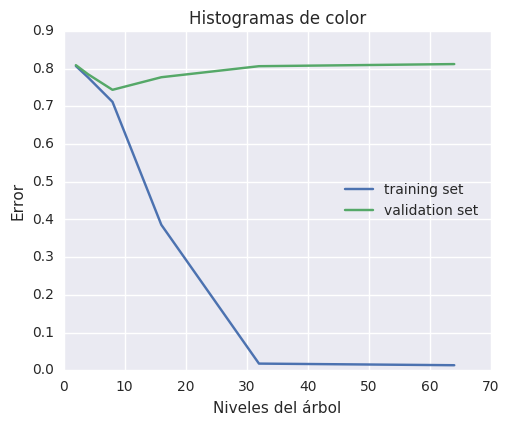

In [72]:
tree_test(features_tr, Ytr, features_val, Yval, 'Histogramas de color')

#### Hog features

In [73]:
features_tr = extract_features(Xtr, [hog_features])
features_te = extract_features(Xte, [hog_features])
features_val = extract_features(Xval, [hog_features])

(42000, 32, 32, 3)
(10000, 32, 32, 3)
(8000, 32, 32, 3)


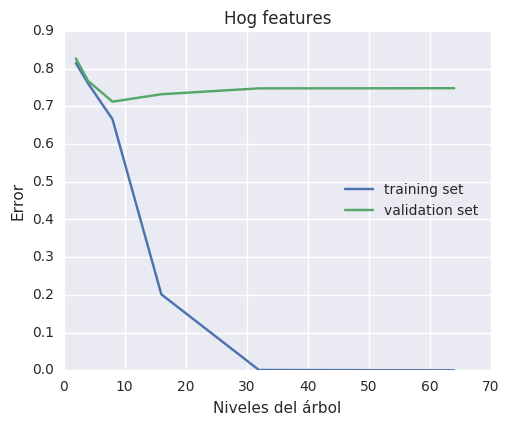

In [74]:
tree_test(features_tr, Ytr, features_val, Yval, 'Hog features')

#### All features

In [7]:
features_tr = extract_features(Xtr, [hog_features, color_histogram_hsv])
features_te = extract_features(Xte, [hog_features, color_histogram_hsv])
features_val = extract_features(Xval, [hog_features, color_histogram_hsv])

(42000, 32, 32, 3)
(10000, 32, 32, 3)
(8000, 32, 32, 3)


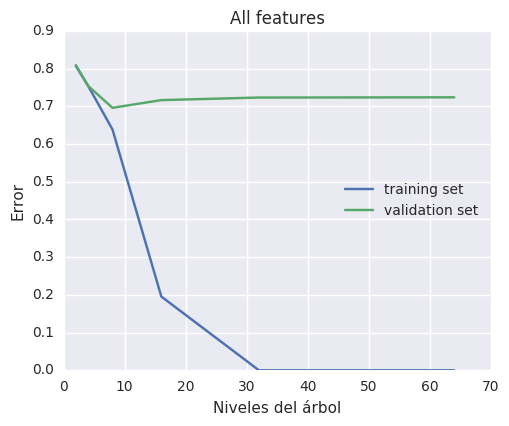

In [10]:
tree_test(features_tr, Ytr, features_val, Yval, 'All features')

Usando árboles de clasificación, se consigue un rendimiento bastante mediocre. Con la excepción del modelo *all features*, todos los demás obtienen un rendimiento por debajo del 30%. En los cuatro casos, el mínimo error de validación se obtiene con un árbol de 8 niveles. Posterior a eso, se produce un evidente overfitting. Se puede rescatar el hecho de que el utilizar una representación basada en histogramas de color, hog features, o ambas en conjunto, se reduce ampliamente la dimensionalidad del problema, lo que conlleva un tiempo de entrenamiento menor.

#### Random forest, píxeles originales
Por defecto, Random forest utiliza como máxima cantidad de features a sqrt(n_features). Esto permite disminuir la dimensionalidad del problema a un aproximado de 55 features (3072 originalmente), por lo que el entrenamiento de los clasificadores (20 árboles de decisión) es más rápido. Como se puede apreciar abajo, el rendimiento de Random Forest es algo más superior que al utilizar un sólo árbol, incluso utilizando los features de alto nivel. 

In [6]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=20, verbose=1)
clf.fit(Xtr, Ytr)
print "Random Forest score: {}".format(clf.score(Xval, Yval))

Random Forest score: 0.393375


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   39.9s finished
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished


#### Random forest, Histogramas de color

In [ ]:
features_tr = extract_features(Xtr, [color_histogram_hsv]) 
features_te = extract_features(Xte, [color_histogram_hsv])
features_val = extract_features(Xval, [color_histogram_hsv])

In [9]:
clf = RandomForestClassifier(n_estimators=20, verbose=1)
clf.fit(features_tr, Ytr)
print "Random Forest score: {}".format(clf.score(features_val, Yval))

Random Forest score: 0.25325


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished


#### Random forest, Hog features

In [10]:
features_tr = extract_features(Xtr, [hog_features])
features_te = extract_features(Xte, [hog_features])
features_val = extract_features(Xval, [hog_features])

(42000, 32, 32, 3)
(10000, 32, 32, 3)
(8000, 32, 32, 3)


In [11]:
clf = RandomForestClassifier(n_estimators=20, verbose=1)
clf.fit(features_tr, Ytr)
print "Random Forest score: {}".format(clf.score(features_val, Yval))

Random Forest score: 0.378375


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   11.7s finished
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished


#### Random forest, all features

In [12]:
features_tr = extract_features(Xtr, [hog_features, color_histogram_hsv])
features_te = extract_features(Xte, [hog_features, color_histogram_hsv])
features_val = extract_features(Xval, [hog_features, color_histogram_hsv])

(42000, 32, 32, 3)
(10000, 32, 32, 3)
(8000, 32, 32, 3)


In [13]:
clf = RandomForestClassifier(n_estimators=20, verbose=1)
clf.fit(features_tr, Ytr)
print "Random Forest score: {}".format(clf.score(features_val, Yval))

Random Forest score: 0.39275


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   11.5s finished
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished


Considerando los modelos de Random forest que utilizan los features de alto nivel para describir los datos, el que presenta los mejores resultados es el que usa histogramas de color + hog features, con un rendimiento un poco mayor al 39%. Este último modelo es preferible al Random Forest que utiliza los píxeles originales, ya que con un accuracy prácticamente igual, la dimensionalidad del problema es evidentemente menor.